In [1]:
import os
import pandas as pd
import seaborn as sns

SEED = 42

In [2]:
def read_solution_file(name, root):
    """Read solution csv to pandas dataframe"""
    dataset = name.split('_')[0]
    key = name.split('_soln')[0]
    n = int(key.split('_')[1])
    columns = ['idx', 'n', 'value']
    columns.extend(list(range(n)))
    columns.append('trailing')
    data = pd.read_csv(os.path.join(root, name), sep=' ', header=None, names=columns)
    data.insert(0, 'dataset', dataset)
    return data

def calculate_rel_error(correct_and_computed):
    """Calculate relative error"""
    correct_value, computed_value = correct_and_computed
    difference = abs(correct_value - computed_value)
    max_value = max(correct_value, computed_value)
    assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
    rel_error = difference/max_value if (max_value > 0) else 0
    return rel_error            


In [3]:
correct_df = None

for root, dirs, files in os.walk("../../data", topdown=False):
    for name in files:
        if ("soln" in name) and (any([k in name for k in ['_0', '_1']])):
            if correct_df is None:
                correct_df = read_solution_file(name, root)
            else:
                correct_df = pd.concat([correct_df, read_solution_file(name, root)])
correct_df = correct_df.drop(['trailing'], axis=1)

computed_df = None

for root, dirs, files in os.walk("../ins_and_outs/outs", topdown=False):
    for name in files:
        if ("soln" in name) and (any([k in name for k in ['_0', '_1']])):
            if computed_df is None:
                computed_df = read_solution_file(name, root)
            else:
                computed_df = pd.concat([computed_df, read_solution_file(name, root)])
computed_df = computed_df.drop(['trailing'], axis=1)


In [4]:
display(
    'correct_df', correct_df.sample(n=5, random_state=SEED),
    'computed_df', computed_df.sample(n=5, random_state=SEED),
)

'correct_df'

,dataset,idx,n,value,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
153,zkw,1042,10,1780,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
194,zkc,195,4,3318,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,zkc,468,10,6366,1,1,0,1,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
441,zkw,880,4,4629,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,nk,319,4,1712,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'computed_df'

,dataset,idx,n,value,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
162,zkw,1086,10,4682,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
168,zkc,169,4,1944,1,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,zkc,214,10,9141,1,1,1,1,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
478,nk,479,4,3988,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,zkc,31,4,3078,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Create comparison dataframe, dataset, index, n and values for correct and computed dataframes
columns = ['dataset', 'idx', 'n', 'value']
# Join correct and computed dataframe on 'dataset', 'idx', 'n'
comparison_df = correct_df[columns].merge(computed_df[columns], on=['dataset', 'idx', 'n'])
# Rename correct and cumputed value columns
comparison_df = comparison_df.rename({'value_x': 'correct', 'value_y': 'computed'}, axis=1)
# Compute relative error
comparison_df['rel_error'] = comparison_df[['correct', 'computed']].apply(calculate_rel_error, axis=1)

display(comparison_df.sample(n=5, random_state=SEED))

,dataset,idx,n,correct,computed,rel_error
4130,zkw,1042,10,1780,0,1.000000
1694,zkc,195,4,3318,3318,0.000000
2476,zkc,468,10,6366,6074,0.045869
3464,zkw,880,4,4629,4629,0.000000
318,nk,319,4,1712,1712,0.000000


In [6]:
# Comparison statistics of correct and computed and relative error
comparison_df.describe()

,idx,n,correct,computed,rel_error
count,4428.000000,4428.000000,4428.000000,4428.000000,4428.000000
mean,484.874887,8.669828,7820.354110,6757.342818,0.139622
std,487.346147,4.552366,10423.129219,9355.305094,0.234850
min,1.000000,4.000000,0.000000,0.000000,0.000000
25%,164.000000,4.000000,3424.750000,2738.000000,0.000000
50%,328.000000,10.000000,6049.000000,4684.500000,0.028551
75%,492.000000,15.000000,10659.750000,9667.500000,0.172123
max,2000.000000,15.000000,270389.000000,270389.000000,1.000000


In [7]:
# Group data by 'dataset' and 'n'
aggregated_df = comparison_df[['dataset', 'n', 'rel_error']].groupby(['dataset', 'n']).agg(['mean', 'max'])
# Flatten rows multiindex 
aggregated_df = aggregated_df.reset_index()
# Flatten columns multiindex (keep last level that is not empty)
aggregated_df.columns = [tup[-1] if tup[-1] != '' else tup[0] for tup in aggregated_df.columns.to_flat_index()]
# From 'mean' and 'max' create 'rel_error_type' and 'rel_error'
aggregated_df = pd.melt(aggregated_df, id_vars=['dataset', 'n'], var_name='rel_error_type', value_name='rel_error')

display(aggregated_df.sample(n=5, random_state=42))

,dataset,n,rel_error_type,rel_error
0,nk,4,mean,0.071923
1,nk,10,mean,0.129484
8,zkw,15,mean,0.218647
5,zkc,15,mean,0.023962
3,zkc,4,mean,0.033493


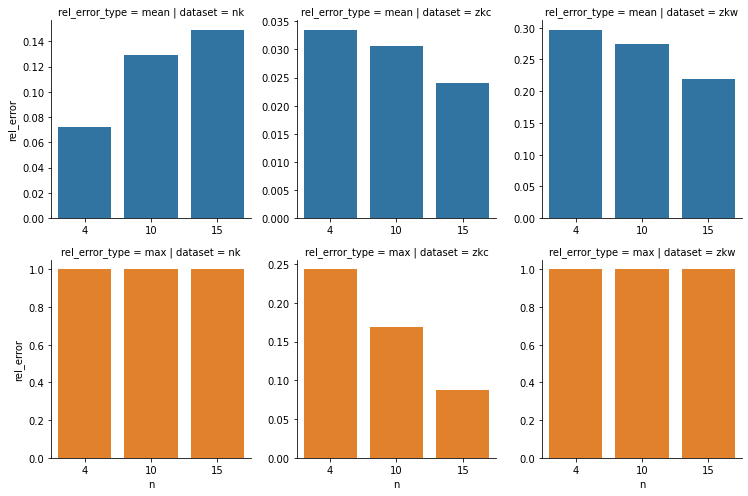

In [8]:
# Create facetgrid datasets in columns, rel_error_type in rows
g = sns.FacetGrid(aggregated_df, col="dataset", row="rel_error_type", hue='rel_error_type', sharey=False, sharex=False, height=3.5) # , hue="score"
# Visualize rel_error as barplot
g.map(sns.barplot, 'n', 'rel_error', order=sorted(aggregated_df['n'].unique()))